In [1]:
import yfinance as yf
import pandas as pd
import os

In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [3]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,0,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,0,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,0,0


<AxesSubplot:xlabel='Date'>

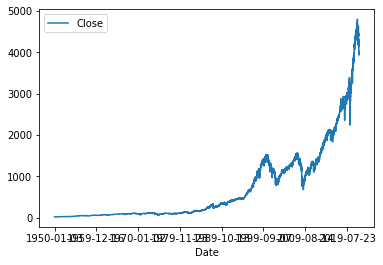

In [4]:
sp500.plot.line(y="Close", use_index=True)

In [5]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [6]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [7]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [8]:
sp500 = sp500.loc["1990-01-01":].copy()

In [9]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.42857142857142855

<AxesSubplot:xlabel='Date'>

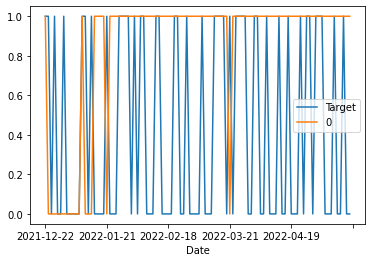

In [12]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [28]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [14]:
def backtest(data, model, predictors, start=1000, step=750):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [15]:
predictions = backtest(sp500, model, predictors)

In [16]:
predictions["Predictions"].value_counts()

0    4192
1    2965
Name: Predictions, dtype: int64

In [17]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5433389544688026

In [18]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.539751
0    0.460249
Name: Target, dtype: float64

In [20]:
horizons = [7,90,365]

for horizon in horizons:
    column = f"Close_{horizon}"
    sp500[column] =  sp500.rolling(horizon).mean()["Close"]
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / sp500[column]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    predictors+= [ratio_column, trend_column]

In [21]:
sp500 = sp500.dropna()

In [22]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_7,Close_Ratio_7,Trend_7,Close_90,Close_Ratio_90,Trend_90,Close_365,Close_Ratio_365,Trend_365
Date,,,,,,,,,,,,,,,,
1991-06-12,381.049988,381.049988,374.459991,376.649994,166140000,377.630005,1,381.737139,0.986674,1.0,374.605666,1.005457,46.0,343.891672,1.095258,191.0
1991-06-13,376.649994,377.899994,376.079987,377.630005,145650000,382.290009,1,380.292855,0.992998,2.0,374.931111,1.007198,46.0,343.943370,1.097942,192.0
1991-06-14,377.630005,382.299988,377.630005,382.290009,167950000,380.130005,0,379.892857,1.006310,3.0,375.275888,1.018691,46.0,344.016302,1.111256,193.0
1991-06-17,382.299988,382.309998,380.130005,380.130005,134230000,378.589996,0,379.392857,1.001943,3.0,375.520999,1.012274,45.0,344.092822,1.104731,193.0
1991-06-18,380.130005,381.829987,377.989990,378.589996,155200000,375.089996,0,379.272858,0.998200,3.0,375.766222,1.007515,45.0,344.160767,1.100038,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,4081.270020,4081.270020,3975.479980,3991.239990,4746120000,4001.050049,1,4146.344273,0.962593,3.0,4433.581660,0.900229,38.0,4270.019368,0.934712,194.0
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0,4127.647112,0.969329,4.0,4424.940771,0.904204,39.0,4271.036903,0.936787,195.0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0,4096.189976,0.960693,3.0,4415.707435,0.891178,39.0,4271.850135,0.921189,194.0


In [33]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [34]:
predictions = backtest(sp500, model, predictors)

In [30]:
predictions["Predictions"].value_counts()

0    3398
1    3393
Name: Predictions, dtype: int64

In [31]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5473032714412025

In [32]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.53836
0    0.46164
Name: Target, dtype: float64